# Xception Model

## Team Members - Harshil Malhotra, Aayushi Raj, Nityam Sharma

### Importing required libraries

Found 4217 files belonging to 4 classes.


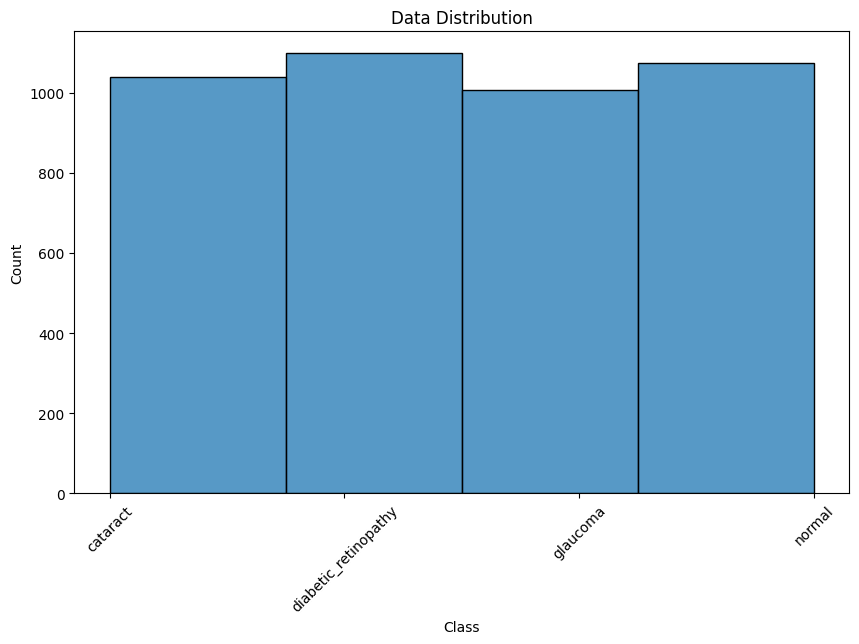

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')
import visualkeras
from pathlib import Path
import PIL
import os
from tqdm import tqdm

# Define custom F1Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Defining batch size and generating training dataset
base_directory = r"D:\Downloads\RetinaXpert-main\RetinaXpert-main\dataset"
image_size = (224, 224)
batch_size = 64

train_data = tf.keras.utils.image_dataset_from_directory(
    directory=base_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=2022
)

# Data Distribution
class_counts = []
for data_batch, label_batch in train_data:
    class_counts.extend(label_batch.numpy())

class_names = train_data.class_names

plt.figure(figsize=(10, 6))
sns.histplot(class_counts, bins=len(class_names), kde=False)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Distribution')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()


### Reading input data

In [4]:
# Set your data directory
data_dir = "D:\Downloads\RetinaXpert-main\RetinaXpert-main\dataset"

### Data Preprocessing

In [5]:
# Function to load and preprocess data
def load_and_preprocess_data(data_dir, img_size):
    class_names = ['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']
    filepaths = []
    labels = []

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for filename in tqdm(os.listdir(class_path), ncols=110, desc=class_name, unit='file', colour='blue'):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
            img = cv2.resize(img, img_size)  # Resize image to desired dimensions
            filepaths.append(filepath)
            labels.append(class_name)

    df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

    # Split the data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, stratify=df['labels'])

    return train_df, test_df, class_names  # Return class_names

# Load and preprocess your data
train_df, test_df, class_names = load_and_preprocess_data(data_dir, img_size=(224, 224))


cataract: 100%|█████████████████████████████████████████████████████████| 1038/1038 [00:22<00:00, 45.16file/s]


### Defining batch size and image dimensions

In [6]:
batch_size = 64
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

### Creating Data using ImageGenerator

In [7]:
# Function to create data generators
def create_data_generators(train_df, test_df, img_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1/255.0, rotation_range=20, vertical_flip=True, shear_range=0.2, dtype=float)
    test_datagen = ImageDataGenerator(rescale=1/255.0, dtype=float)

    train_set = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
    test_set = test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)

    return train_set, test_set

In [8]:
# Create data generators
train_set, test_set = create_data_generators(train_df, test_df, (img_height, img_width), batch_size)

Found 3373 validated image filenames belonging to 4 classes.
Found 844 validated image filenames belonging to 4 classes.


### Defining the Xception model

In [9]:
def generate_xception_model(input_shape, num_classes):
    xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(xception_base.output)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=xception_base.input, outputs=predictions)

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1Score(num_classes=num_classes)])
    
    return model

In [13]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [14]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def generate_xception_model(input_shape, num_classes):
    xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(xception_base.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=xception_base.input, outputs=predictions)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1Score()])
    
    return model


### Generating the Xception model

In [15]:
num_classes = len(class_names)
xception_model = generate_xception_model(input_shape, num_classes)

In [16]:
# Display model summary
xception_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

### Training the model

In [17]:
epochs = 10
history = xception_model.fit(train_set, epochs=epochs, validation_data=test_set)

Epoch 1/10
53/53 [==============================] - 782s 14s/step - loss: 0.5613 - accuracy: 0.7889 - f1_score: 0.7799 - val_loss: 3.4621 - val_accuracy: 0.5770 - val_f1_score: 0.5753
Epoch 2/10
53/53 [==============================] - 758s 14s/step - loss: 0.2984 - accuracy: 0.8933 - f1_score: 0.8937 - val_loss: 2.1164 - val_accuracy: 0.6742 - val_f1_score: 0.6758
Epoch 3/10
53/53 [==============================] - 758s 14s/step - loss: 0.2440 - accuracy: 0.9119 - f1_score: 0.9126 - val_loss: 0.8806 - val_accuracy: 0.8412 - val_f1_score: 0.8427
Epoch 4/10
53/53 [==============================] - 760s 14s/step - loss: 0.2110 - accuracy: 0.9229 - f1_score: 0.9240 - val_loss: 2.2516 - val_accuracy: 0.6955 - val_f1_score: 0.6949
Epoch 5/10
53/53 [==============================] - 760s 14s/step - loss: 0.2010 - accuracy: 0.9345 - f1_score: 0.9348 - val_loss: 0.2659 - val_accuracy: 0.8981 - val_f1_score: 0.8989
Epoch 6/10
53/53 [==============================] - 762s 14s/step - loss: 0.1345

### Saving the trained model

In [18]:
xception_model.save('xception_model.h5')
print("Model saved successfully.")

Model saved successfully.


### Evaluating the model on the test set

In [19]:
evaluation = xception_model.evaluate(test_set)

14/14 [==============================] - 41s 3s/step - loss: 0.3705 - accuracy: 0.9135 - f1_score: 0.9139


In [20]:
# Print evaluation results
print("\nEvaluation Results:")
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")


Evaluation Results:
Test Loss: 0.3705
Test Accuracy: 91.35%


### Plotting training history

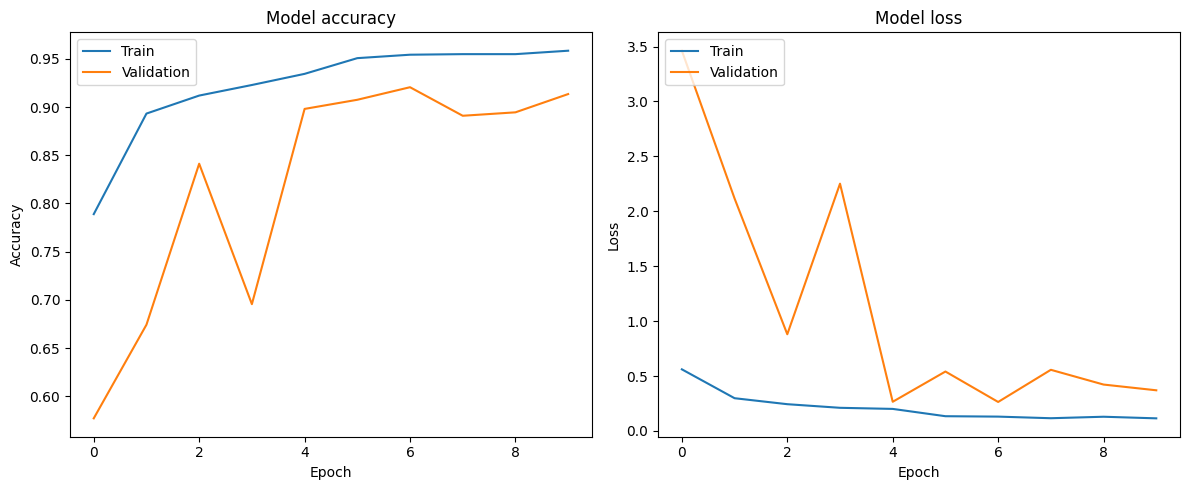

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])  # Use 'accuracy' instead of 'categorical_accuracy'
    plt.plot(history.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_categorical_accuracy'
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)


In [24]:
plt.savefig("score.png",dpi=200)

<Figure size 640x480 with 0 Axes>

### Generating predictions for the test set

In [25]:
predictions = xception_model.predict(test_set, steps=test_set.n // batch_size)

13/13 [==============================] - 41s 3s/step


In [27]:
# Use test_set.classes directly for class indices
y_true = test_set.classes
y_pred = np.argmax(predictions, axis=1)

### Ploting the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


NameError: name 'test_true_labels' is not defined

### Generating and printing the classification report

In [30]:
# Use the original labels from the generator
test_true_labels = test_set.classes

# If the true labels are not one-hot encoded, convert them
if isinstance(test_true_labels[0], list):
    test_true_labels = np.argmax(test_true_labels, axis=1)

# Convert predictions to class labels
test_pred_labels = np.argmax(predictions, axis=1)

# Ensure both arrays have the same length
min_length = min(len(test_true_labels), len(test_pred_labels))
test_true_labels = test_true_labels[:min_length]
test_pred_labels = test_pred_labels[:min_length]

# Print the classification report
class_report = classification_report(test_true_labels, test_pred_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
                       precision    recall  f1-score   support

              normal       0.23      0.21      0.22       206
            glaucoma       0.31      0.31      0.31       217
diabetic_retinopathy       0.21      0.25      0.23       199
            cataract       0.21      0.18      0.19       210

            accuracy                           0.24       832
           macro avg       0.24      0.24      0.24       832
        weighted avg       0.24      0.24      0.24       832



In [36]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load model


In [38]:
model = load_model('xception_model.h5')

# Load and preprocess image


In [64]:
img = image.load_img(r"D:\Downloads\RetinaXpert-main\RetinaXpert-main\dataset\cataract\2158_right.jpg", target_size=(224, 224))  # Replace with your input size
img_array = image.img_to_array(img) / 255.0  # Normalize if required
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction


In [65]:
predictions = model.predict(img_array)

# Post-process and interpret results
predicted_class = np.argmax(predictions, axis=-1)
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 116ms/step
Predicted class: [0]
